In [2]:
import sys, os, re, csv, codecs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.models import Model, model_from_json
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers, regularizers, constraints, optimizers, layers



In [ ]:
!pip install pad_sequences

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pad-sequences: filename=pad_sequences-0.6.1-py3-none-any.whl size=10216 sha256=cb40269035dce0e320e5c576630134012a86d3d496598c1ea13dabca725a7666
  Stored in directory: /root/.cache/pip/wheels/51/e4/5c/d3610ed4476515e540ff4096e3e9a8a3e701dedfe1072eb000
Successfully built pad-sequences


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train = pd.read_csv('/content/drive/MyDrive/dataset/train.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')
testLabel = pd.read_csv('/content/drive/MyDrive/dataset/test_labels.csv')

train = train.sample(frac=1)
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
46276,7ba07580d1024706,"""\n\n """"definite form"""" \n\nI notice Factuariu...",0,0,0,0,0,0
64906,adacf4e274e85368,"""\n1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 10, 11, 12, 1...",0,0,0,0,0,0
106100,37aad0a2788a8447,Purple Buds \n\nHey all I just had a quick que...,0,0,0,0,0,0
8120,159bba8a46febea9,I've made a start - won't be able to do much m...,0,0,0,0,0,0
80418,d727b747a62d23fc,Actually You seems to be over smart.No one is ...,0,0,0,0,0,0


In [7]:
#checking for nulls
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
 test.isnull().any()

id              False
comment_text    False
dtype: bool

In [9]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [10]:
y = train[list_classes].values

In [11]:
list_sentences_train = train["comment_text"].fillna("CVxTz").values
list_sentences_test = test["comment_text"].fillna("CVxTz").values

In [12]:
max_features = 20000
maxlen = 100
embed_size = 350  
lstm_output = 50
relu_output = 50
dropout1 = 0.20
dropout2 = 0.20
weight_file_path = "lstm_weights_{}_{}_{}_{}_{}_{}_{}.ckpt"\
    .format(max_features, maxlen, embed_size, lstm_output, relu_output, int(dropout1*100), int(dropout2*100))

model_file_path = "lstm_model_{}_{}_{}_{}_{}_{}_{}.json"\
    .format(max_features, maxlen, embed_size, lstm_output, relu_output, int(dropout1*100), int(dropout2*100))

**Tokenization**

In [13]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

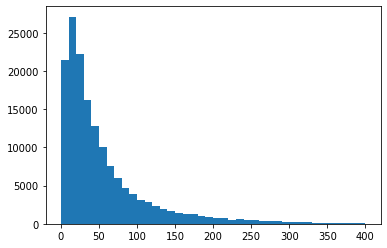

In [14]:
#check the distribution of the number of words in sentences
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]
plt.hist(totalNumWords, bins=np.arange(0, 410, 10))
plt.show()

In [15]:
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)
print(X_train)
print(X_test)

[[    0     0     0 ...   640   428  8544]
 [    0     0     0 ...  4850  1080 17540]
 [    0     0     0 ...    18    54   666]
 ...
 [    7    33    14 ...  2123   469   182]
 [    0     0     0 ...    37   331    11]
 [    3     1   440 ...     2    42   222]]
[[   0    0    0 ...  145  493   84]
 [   0    0    0 ...   11    8 2826]
 [   0    0    0 ...  109   15  355]
 ...
 [   0    0    0 ...   12 1651  358]
 [   0    0    0 ... 9779 3501  355]
 [   0    0    0 ...  100 5230    6]]


**Model Defining**

In [16]:
def createModel():
  inputData = Input(shape=(maxlen,))
  x = Embedding(max_features, embed_size)(inputData)      
  x = Bidirectional(LSTM(lstm_output, return_sequences=True, name='lstm_layer'))(x)
  x = GlobalMaxPool1D()(x)
  x = Dropout(dropout1)(x)
  x = Dense(relu_output, activation="relu")(x)
  x = Dropout(dropout2)(x)
  x = Dense(6, activation="sigmoid")(x)

  model = Model(inputs=inputData, outputs=x)

  return model



In [17]:
def loadModel():
    try:
        # load json and create model
        json_file = open(model_file_path, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)

        # load weights into new model
        # model.load_weights("model.h5")
        loadWeights(model)
        print("Loaded model from disk")
        return model

    except Exception:
        model = createModel()
        print("Creating new model")
        return model

def saveModel(model):
    # serialize model to JSON
    model_json = model.to_json()
    with open(model_file_path, "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    # model.save_weights("model.h5")
    print("Saved model to disk")

In [18]:
def testModel(model, X_test):
    y_test = model.predict(X_test)

In [20]:
def setupEarlyStop():
    checkpoint = ModelCheckpoint(weight_file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early = EarlyStopping(monitor="val_loss", mode="min", patience=30)
    callbacks_list = [checkpoint, early]

    return callbacks_list

def loadWeights(model):
    try:
        print('Loading weights...')
        model.load_weights(weight_file_path)
    except IOError:
        print('No weight file, creating one...')

**Training**

In [22]:
model = loadModel()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  

callbacks_list = setupEarlyStop()

model.fit(X_train, y, batch_size=32, epochs=2, validation_split=0.05, callbacks=callbacks_list)
model.summary()
saveModel(model)
loadWeights(model)

# test model (predicting)
testModel(model, X_test)

# save the prediction for training
trainResult = model.predict(X_train)

Creating new model
Epoch 1/2
4738/4738 [==============================] - ETA: 0s - loss: 0.0617 - accuracy: 0.9237
Epoch 1: val_loss improved from inf to 0.04702, saving model to lstm_weights_20000_100_350_50_50_20_20.ckpt


4738/4738 [==============================] - 1552s 327ms/step - loss: 0.0617 - accuracy: 0.9237 - val_loss: 0.0470 - val_accuracy: 0.9937
Epoch 2/2
4738/4738 [==============================] - ETA: 0s - loss: 0.0442 - accuracy: 0.9733
Epoch 2: val_loss improved from 0.04702 to 0.04646, saving model to lstm_weights_20000_100_350_50_50_20_20.ckpt


4738/4738 [==============================] - 1548s 327ms/step - loss: 0.0442 - accuracy: 0.9733 - val_loss: 0.0465 - val_accuracy: 0.9936
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 100, 350)          7000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 100)         160400    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 100)             